In [3]:
import torch 
import torch.nn as nn
from train import build
import os 
from pathlib import Path
from dynRNN.task import CopyFirstInput
import matplotlib.pyplot as plt
from tqdm import trange

CONFIG = {
    'mem_size' : 64,
    'better_init_GRU': 'BiGRU',
    'device': 'cuda'
}

run_name = 'dashing-rain-450_dz8jndcm' #BiGRU

# run_name = 'helpful-totem-494_ng8a765l' #nBRC best
# run_name = 'likely-planet-494_0wcqwffd' #nBRC avg

# run_name =  'atomic-puddle-474_jkhrz92y' #GRU broken
# run_name = 'still-firebrand-475_2byw36h2' #GRU best

# run_name =  'tricky-candle-514_bo6zya8p' #LSTM broken
# run_name = 'mischievous-cat-514_ddhyuyoq' #LSTM best

SCRATCH = os.environ.get('SCRATCH', '.')
PATH = Path(SCRATCH) / f'GRU_dyn/Cpy1in/runs/{run_name}/checkpoint.pth'

rnn, decoder = build(**CONFIG)
mod = torch.load(PATH)

# rnn.load_state_dict(mod['rnn_check'])
# decoder.load_state_dict(mod['decoder_check'])

rnn.eval()
decoder.eval()

Linear(in_features=64, out_features=1, bias=True)

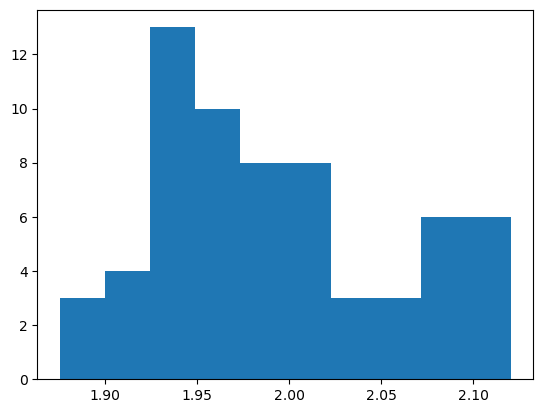

torch.Size([1000000, 64])


In [4]:
plt.hist(rnn.weight_hh_l0[2*64:3*64].diag().detach().cpu())
plt.show()

x = torch.linspace(-2, 2, 1000)
y = torch.linspace(-1.1, 1.1, 1000)

xy_grid = torch.meshgrid(x, y, indexing="ij")

c_g = xy_grid[0].T
h_g = xy_grid[1].T.flip(0, 1)
h_0 = torch.zeros((h_g.numel(),64))
h_0[:,0] = h_g.view(-1)
c_0 = torch.zeros((h_g.numel(),64))
c_0[:,0] = h_g.view(-1)

print(c_0.shape)

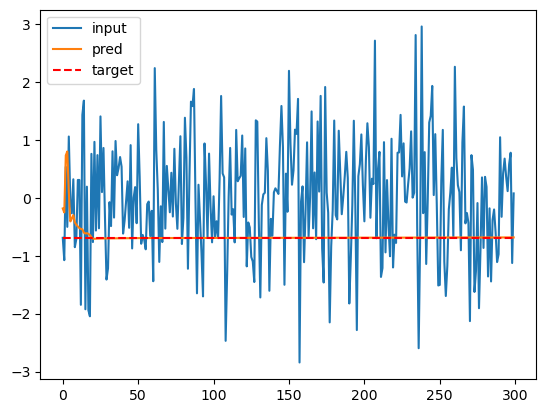

In [61]:
with torch.no_grad():
    data = CopyFirstInput.get_batch(1, 300)
    
    traj = rnn(data.to(CONFIG['device']))[0]
    prediction = decoder(traj)
    CopyFirstInput.show_pred(prediction[0].cpu(), data[0])

In [62]:
class LayerNorm(nn.Module):
    def __init__(self, dim, eps = 1e-5):
        super().__init__()
        self.dim = dim
        self.eps = eps

    def forward(self, x):
        var, mu = torch.var_mean(x, dim = self.dim, keepdim = True, unbiased = True)
        # print(var, mu)
        return (x - mu)/(var + self.eps).sqrt()
    
class LowDimProj(nn.Module):
    def __init__(self, high_sz, proj_sz, hidden):
        super().__init__()
        self.act = nn.Tanh()
        self.encoder = nn.ModuleList([nn.Linear(i,j) for i,j in zip((high_sz,)+hidden, hidden+(proj_sz,))])
        hidden = tuple(reversed(hidden))
        self.decoder = nn.ModuleList([nn.Linear(i,j) for i,j in zip((proj_sz,)+hidden, hidden+(high_sz,))])
        self.norm = LayerNorm(-1)
        
    def encode(self,x):
        for e in self.encoder[:-1]:
            x = self.act(e(self.norm(x)))
        
        return self.encoder[-1](x)
    
    def decode(self,x):
        for d in self.decoder[:-1]:
            x = self.act(d(self.norm(x)))
        
        return self.decoder[-1](x)
    
    def loss(self, x, w=1e-3):
        Loss = nn.MSELoss()
        z = self.encode(x)
        
        return Loss(self.decode(z),x) + w*z.norm()
            
        
trajNet = LowDimProj(64, 2, (64,32,16,8)).to(CONFIG['device'])
epoch = 2048
batch = 512
optim = torch.optim.AdamW(trajNet.parameters(), lr=1e-3, weight_decay=1e-4)
evaluate = 1024
data_eval = CopyFirstInput.get_batch(10, 300).to(CONFIG['device'])
with torch.no_grad():
    data_eval = rnn(data_eval)[0]
    
    

0.07272505015134811:   0%|          | 0/2048 [00:00<?, ?it/s]

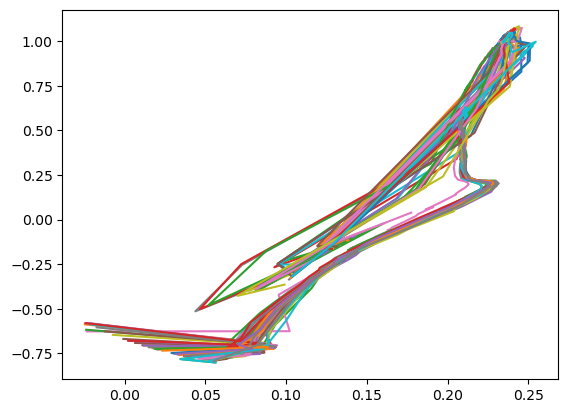

0.07353813201189041:  50%|████▉     | 1020/2048 [00:11<00:11, 89.36it/s]

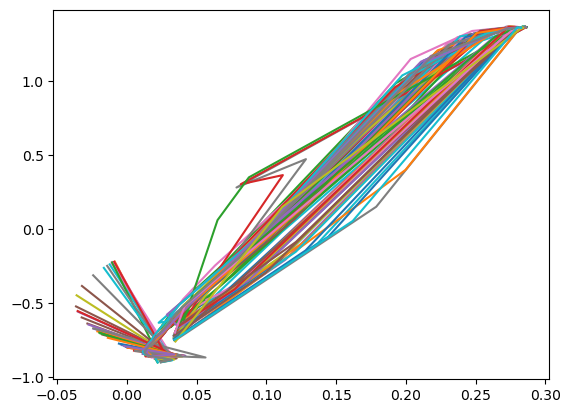

0.07345176488161087: 100%|██████████| 2048/2048 [00:23<00:00, 86.73it/s]


In [66]:
for e in (pbar := trange(epoch)):
    trajNet.train()
    with torch.no_grad():
        data = CopyFirstInput.get_batch(batch, 100)

        traj = rnn(data.to(CONFIG['device']))[0]
    
    l = trajNet.loss(traj,w=0)
    pbar.set_description(str(l.item()))
    l.backward()
    optim.step()
    optim.zero_grad()
    
    if (e % evaluate) == 0:
        trajNet.eval()
        with torch.no_grad():
            proj = trajNet.encode(data_eval)
            for p in proj:
                plt.plot(p[:,0].cpu(),p[:,1].cpu())
            plt.show()

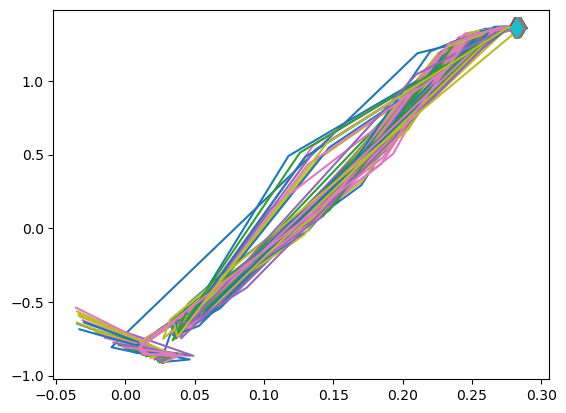

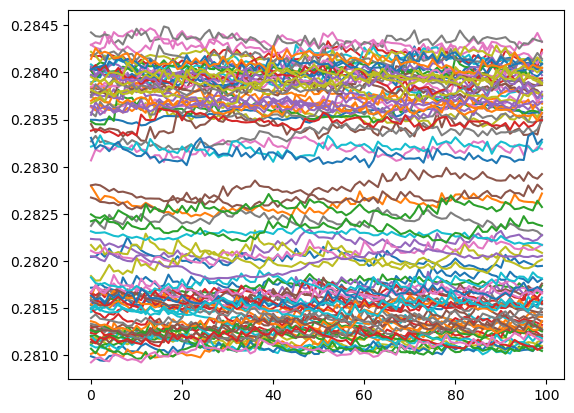

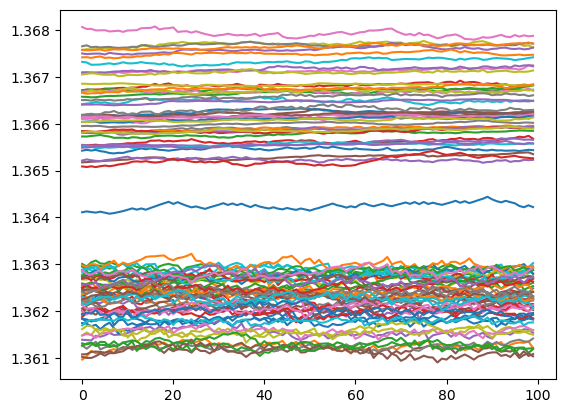

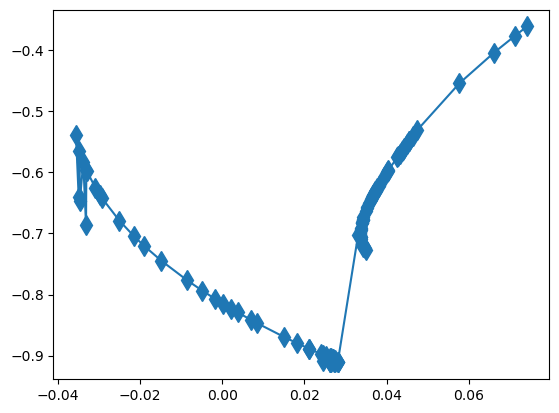

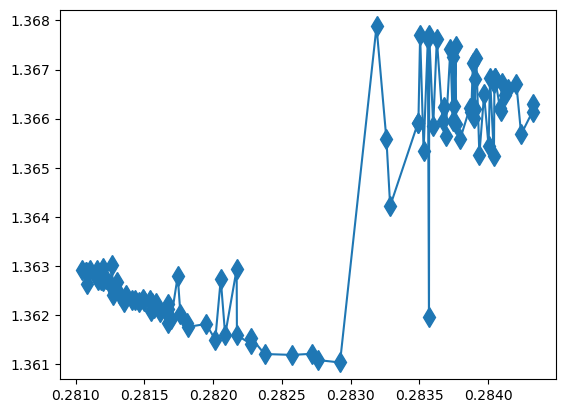

In [67]:
data_eval = CopyFirstInput.get_batch(100, 300).to(CONFIG['device'])
with torch.no_grad():
    data_eval = rnn(data_eval)[0]
    proj = trajNet.encode(data_eval)
    for p in proj:
        plt.plot(p[:,0].cpu(),p[:,1].cpu())
        plt.plot(p[-1,0].cpu(),p[-1,1].cpu(), marker='d', markersize=10)
    plt.show()
    for p in proj:
        plt.plot(p[-100:,0].cpu())
    plt.show()
    for p in proj:
        plt.plot(p[-100:,1].cpu())
    plt.show()
    
    x, idx = torch.sort(proj[:,0,0])
    plt.plot(x.cpu(),proj[idx,0,1].cpu(), marker='d', markersize=10)
    plt.show()
    
    x, idx = torch.sort(proj[:,-1,0])
    plt.plot(x.cpu(),proj[idx,-1,1].cpu(), marker='d', markersize=10)
    plt.show()